# IoU

In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import torch

from torchmetrics import JaccardIndex
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load Split Indexes
train_indexes = np.load("./train_indexes.npy")
test_indexes = np.load("./test_indexes.npy")

print(f"train_indexes ({len(train_indexes)}): {train_indexes}")
print(f"test_indexes ({len(test_indexes)}): {test_indexes}")

train_indexes (240): [ 50 102 134 284  25 252 144 151 242 307 314 198 154 156 177 142 277 231
 207 170  60  79 303 108 173  11 165 220  26 300  56 201 129 114  21 248
 183 163 155 136 159 306 210 313 227 203 181 226 244  54 193 239 276 219
  86  92 130 294 115 139   6 229 111  18 302 272 194  40 288 119  97  43
 271 281  15  51 234 150 103  87  57   9 153 285  59 208 254 310   7 172
 120 240 215 317  46  36 152  76 141 237 273  75  38 184  70 143 223 269
  24  71 291  81 316 216 305  89 233   2 132  10 283  96 218 297 164 188
  14 225 182  49 189 169 251 309 301 308 171 105  72 257  64  67  90 250
 304  78 241 200  33 311 298 299 256  69 107  39 287  13 191 258   1   4
 179  82 185 279 162  31  91  27 278  28 228  41  45 262  93 268 167 101
  65  30 270  98 202 217 124 161 280 290 249 180  66 247 158  37 116 212
 140  16  95 168 253 135  42 109 121 260 197 224 123  61 236 106  63 125
  20 264 266 205 222 199 261  53 209 118 127 149  88 157  62 186 131  84
   8 122 295  19 204  44]
test

In [3]:
EPOCH = 500

In [4]:
with open(f"./targets.p", "rb") as targets_file:
    targets = pickle.load(targets_file)
    targets = np.vstack([t.numpy() for t in targets])
    print(targets)

with open(f"./predictions/{EPOCH}.p", "rb") as prediction_file:
    predictions = pickle.load(prediction_file)
    predictions = np.array(predictions)
    print(predictions)

[[23.]
 [12.]
 [32.]
 [ 9.]
 [ 5.]
 [17.]
 [27.]
 [ 5.]
 [12.]
 [11.]
 [ 9.]
 [17.]
 [26.]
 [12.]
 [ 9.]
 [15.]
 [ 9.]
 [16.]
 [ 9.]
 [38.]
 [10.]
 [29.]
 [15.]
 [ 6.]
 [18.]
 [43.]
 [ 0.]
 [18.]
 [21.]
 [13.]
 [ 9.]
 [ 8.]
 [44.]
 [17.]
 [11.]
 [19.]
 [ 9.]
 [18.]
 [30.]
 [24.]
 [17.]
 [18.]
 [10.]
 [63.]
 [ 9.]
 [ 6.]
 [19.]
 [34.]
 [39.]
 [14.]
 [22.]
 [ 5.]
 [22.]
 [11.]
 [ 2.]
 [62.]
 [ 9.]
 [10.]
 [43.]
 [11.]
 [23.]
 [12.]
 [28.]
 [20.]
 [ 9.]
 [13.]
 [ 9.]
 [ 7.]
 [ 7.]
 [ 5.]
 [39.]
 [19.]
 [17.]
 [11.]
 [22.]
 [27.]
 [23.]
 [ 8.]]
[[21.]
 [ 6.]
 [18.]
 [13.]
 [12.]
 [ 7.]
 [38.]
 [12.]
 [13.]
 [11.]
 [20.]
 [17.]
 [39.]
 [ 9.]
 [15.]
 [17.]
 [30.]
 [22.]
 [ 9.]
 [12.]
 [12.]
 [19.]
 [12.]
 [18.]
 [15.]
 [40.]
 [ 8.]
 [16.]
 [17.]
 [17.]
 [ 6.]
 [ 8.]
 [35.]
 [20.]
 [ 6.]
 [24.]
 [10.]
 [24.]
 [31.]
 [19.]
 [32.]
 [16.]
 [17.]
 [32.]
 [16.]
 [ 8.]
 [30.]
 [30.]
 [35.]
 [19.]
 [19.]
 [15.]
 [22.]
 [ 5.]
 [ 6.]
 [20.]
 [14.]
 [23.]
 [29.]
 [14.]
 [29.]
 [ 7.]
 [15.]
 [17.]
 [10.

In [5]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(targets, predictions))

# Calculate R2 score
r2 = r2_score(targets, predictions)

print("RMSE:", rmse)
print("R2 score:", r2)

RMSE: 9.73429
R2 score: 0.3808739515407793


/tmp/ipykernel_3664954/3191357821.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis")


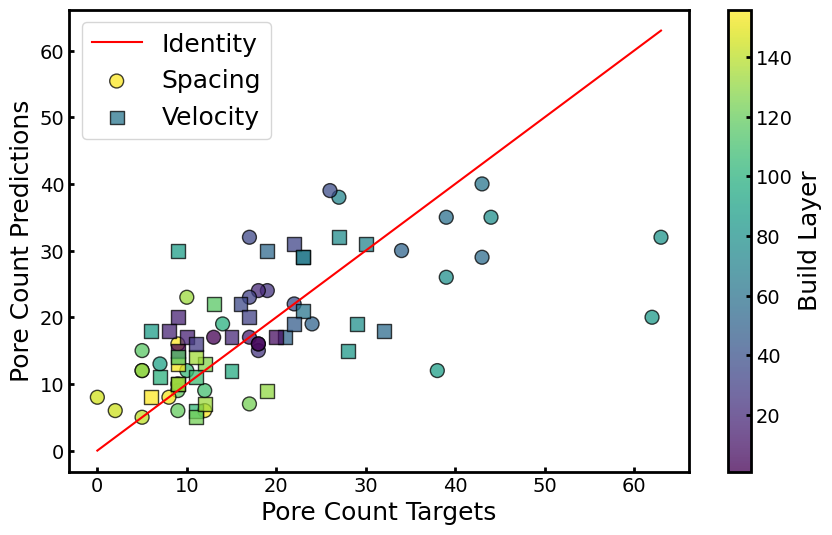

In [6]:
# Create a plot
BUILD_LAYERS = 159
dataset_index = [divmod(layer_index, 159)[0] for layer_index in test_indexes]
dataset_markers = np.array(["o" if index == 0 else "s" for index in dataset_index])
colored_layers = np.array([divmod(layer_index, 159)[1] for layer_index in test_indexes])
cmap = cm.get_cmap("viridis")
# plt.scatter(targets, predictions, c=colored_layers, cmap=cmap, marker=dataset_markers)

unique_markers = np.unique(dataset_markers)  # or yo can use: np.unique(m)

x = targets.flatten()
y = predictions.flatten()

plt.figure(figsize=(10, 6))

plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r-', label="Identity")
for marker in ["o", "s"]:
    mask = dataset_markers == marker
    # mask is now an array of booleans that can be used for indexing
    label = "Velocity"
    if (marker == "o"):
        label = "Spacing"
    plt.scatter(x[mask], y[mask], marker=marker, c=colored_layers[mask], cmap=cmap, label=label, s=100, alpha=0.75, edgecolor="black")

cbar = plt.colorbar()
cbar.ax.tick_params(direction="in", labelsize=14, width=2)
cbar.outline.set_linewidth(2)
cbar.set_label("Build Layer", fontsize=18)

# Set labels and title
plt.xlabel('Pore Count Targets', fontsize=18)
plt.ylabel("Pore Count Predictions", fontsize=18)
# plt.title(f"Pore Count", fontsize=24, pad=20)
plt.tick_params(direction="in", labelsize=14, width=2)
plt.legend(fontsize=18)

# Increase border thickness
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

# Show plot
plt.show()